In [1]:
import pandas as pd
import sklearn
import itertools
import numpy as np
import seaborn as sb
import re
import nltk
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from sklearn.linear_model import PassiveAggressiveClassifier,LogisticRegression
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [2]:
train_df = pd.read_csv('train.csv')

In [3]:
train_df.head(15)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0
9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0


In [4]:
train_df.shape

(20800, 5)

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [6]:
# def create_distribution(dataFile):
#     return sb.countplot(x='label', data=dataFile, palette='hls')

# #by calling below we can see that training, test and valid data seems to be failry evenly distributed between the classes
# create_distribution(train_df)
train_df['label'].value_counts().values

array([10413, 10387], dtype=int64)

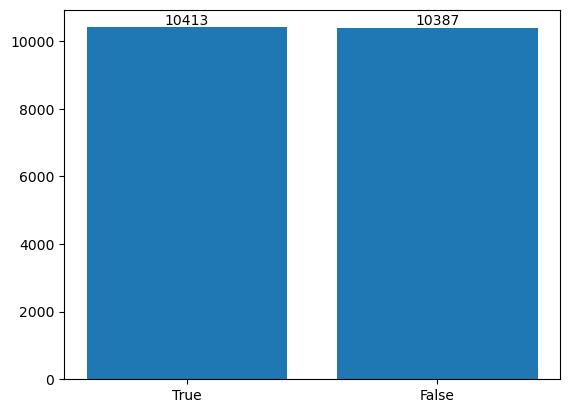

In [7]:
bars= plt.bar(['True','False'],train_df['label'].value_counts().values)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()
#Hence data has nearly equal cases of True and False News.

In [8]:
def data_qualityCheck():
    print("{:{}}".format("\033[1mCOLUMN\033[0m",38),end='')
    print("{:{}}".format("\033[1mNULL VALUES COUNT\033[0m",18))
    for x in train_df.columns:
        print("{:{}}".format(x,34),end='')
        print(train_df[x].isnull().sum())

    
data_qualityCheck()

COLUMN                        NULL VALUES COUNT
id                                0
title                             558
author                            1957
text                              39
label                             0


In [9]:
train_df=train_df.drop(["id", "author"], axis=1)

In [13]:
train_df.shape

(20800, 3)

In [14]:
train_df.head()

,title,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,1


In [15]:
label_train = train_df['label']
label_train

0        1
1        0
2        1
3        1
4        1
        ..
20795    0
20796    0
20797    0
20798    1
20799    1
Name: label, Length: 20800, dtype: int64

In [16]:
label_train.head(10)

0    1
1    0
2    1
3    1
4    1
5    0
6    1
7    0
8    0
9    0
Name: label, dtype: int64

In [17]:
train_df = train_df.drop("label", axis = 1)

In [18]:
train_df.head(10)

,title,text
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ..."
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...
5,Jackie Mason: Hollywood Would Love Trump if He...,"In these trying times, Jackie Mason is the Voi..."
6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,Ever wonder how Britain’s most iconic pop pian...
7,Benoît Hamon Wins French Socialist Party’s Pre...,"PARIS — France chose an idealistic, traditi..."
8,Excerpts From a Draft Script for Donald Trump’...,Donald J. Trump is scheduled to make a highly ...
9,"A Back-Channel Plan for Ukraine and Russia, Co...",A week before Michael T. Flynn resigned as nat...


In [19]:
def fill_data(data):
    data["title"] = data["title"].fillna("Has No Title")
    data["text"] = data["text"].fillna("Has No text")
    return data

train_df= fill_data(train_df)

In [20]:
data_qualityCheck()

COLUMN                        NULL VALUES COUNT
title                             0
text                              0


In [21]:
train_df.head(20)

,title,text
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ..."
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...
5,Jackie Mason: Hollywood Would Love Trump if He...,"In these trying times, Jackie Mason is the Voi..."
6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,Ever wonder how Britain’s most iconic pop pian...
7,Benoît Hamon Wins French Socialist Party’s Pre...,"PARIS — France chose an idealistic, traditi..."
8,Excerpts From a Draft Script for Donald Trump’...,Donald J. Trump is scheduled to make a highly ...
9,"A Back-Channel Plan for Ukraine and Russia, Co...",A week before Michael T. Flynn resigned as nat...


In [22]:
train_df["new_text"] = train_df["title"] + " " + train_df["text"]

In [23]:
train_df.head(20)

,title,text,new_text
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",Why the Truth Might Get You Fired Why the Trut...
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,15 Civilians Killed In Single US Airstrike Hav...
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,Iranian woman jailed for fictional unpublished...
5,Jackie Mason: Hollywood Would Love Trump if He...,"In these trying times, Jackie Mason is the Voi...",Jackie Mason: Hollywood Would Love Trump if He...
6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,Ever wonder how Britain’s most iconic pop pian...,Life: Life Of Luxury: Elton John’s 6 Favorite ...
7,Benoît Hamon Wins French Socialist Party’s Pre...,"PARIS — France chose an idealistic, traditi...",Benoît Hamon Wins French Socialist Party’s Pre...
8,Excerpts From a Draft Script for Donald Trump’...,Donald J. Trump is scheduled to make a highly ...,Excerpts From a Draft Script for Donald Trump’...
9,"A Back-Channel Plan for Ukraine and Russia, Co...",A week before Michael T. Flynn resigned as nat...,"A Back-Channel Plan for Ukraine and Russia, Co..."


In [24]:
train_df=train_df.drop(['title','text'],axis=1)

In [25]:
train_df.head()

,new_text
0,House Dem Aide: We Didn’t Even See Comey’s Let...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,Why the Truth Might Get You Fired Why the Trut...
3,15 Civilians Killed In Single US Airstrike Hav...
4,Iranian woman jailed for fictional unpublished...


In [26]:
custom_download_dir = "C:\\Users\\ysach/nltk"
nltk.data.path.append(custom_download_dir)

In [31]:
nltk.download('stopwords',download_dir=custom_download_dir)

[nltk_data] Downloading package stopwords to C:\Users\ysach/nltk...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
lemmatizer = WordNetLemmatizer()
stpwrds = list(stopwords.words('english'))

In [33]:
stpwrds

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [34]:
nltk.download('punkt',download_dir=custom_download_dir)
nltk.download('wordnet',download_dir=custom_download_dir)

[nltk_data] Downloading package punkt to C:\Users\ysach/nltk...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\ysach/nltk...
[nltk_data]   Package wordnet is already up-to-date!


True

In [35]:
nltk.download('omw-1.4',download_dir=custom_download_dir)

[nltk_data] Downloading package omw-1.4 to C:\Users\ysach/nltk...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [36]:
for x in range(len(train_df)) :
    corpus = []
    review = train_df['new_text'][x]
    review = re.sub(r'[^a-zA-Z\s]', '', review)
    review = review.lower()
    review = nltk.word_tokenize(review)
    for y in review :
        if y not in stpwrds :
            corpus.append(lemmatizer.lemmatize(y))
    review = ' '.join(corpus)
    train_df['new_text'][x] = review

In [37]:
train_df['new_text'][2188]

'actor steven seagal live tv erupts hillary obama intense comment actor steven seagal stood america rest hollywood remains silent week rough country first democratic nominee hillary clinton collapsed memorial called million hardworking american deplorable werent enough nfl player throughout country blatantly disrespecting american flag needle say seagal enough think important job secretary state ensuring people dont get killed seagal tweeted cant email protected pneumonia going disastrous american people notohillary continued course seagal quickly became target liberal fire comment refused break particularly lost one twitter user tried argued hillary capable presidency capable capable leaving american die capable disregarding law capable disrespecting rape survivor argued went address race relation united state true role president barack obama played social evolution country obama abysmal race relation usa truth need start honest dialog wrote seagal concluded pointing irony attack rece

In [75]:
label_train[2188]

1

In [38]:
X_train= train_df['new_text']

In [39]:
X_train

0        house dem aide didnt even see comeys letter ja...
1        flynn hillary clinton big woman campus breitba...
2        truth might get fired truth might get fired oc...
3        civilian killed single u airstrike identified ...
4        iranian woman jailed fictional unpublished sto...
                               ...                        
20795    rapper ti trump poster child white supremacy r...
20796    nfl playoff schedule matchup odds new york tim...
20797    macys said receive takeover approach hudson ba...
20798    nato russia hold parallel exercise balkan nato...
20799    keep f alive david swanson author activist jou...
Name: new_text, Length: 20800, dtype: object

In [40]:
X_train.shape

(20800,)

In [41]:
label_train.shape

(20800,)

In [42]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [43]:
tokenize = Tokenizer(oov_token="<OOV>")
tokenize.fit_on_texts(X_train)
word_idx = tokenize.word_index

text2seq = tokenize.texts_to_sequences(X_train)

# pad_seq = pad_sequences(text2seq, maxlen=150, padding="pre", truncating="pre")

pad_seq = pad_sequences(text2seq, padding="pre", truncating="pre")


print("The Padding Sequance Shape is  --> ", pad_seq.shape)

The Padding Sequance Shape is  -->  (20800, 12140)


In [46]:
input_length = max(len(seq) for seq in text2seq)

vocabulary_size = len(word_idx) + 1

In [47]:
print("The maximum Sequance Length is  --> ", input_length)
print("The vocabulary size of dataset is  --> ", vocabulary_size)

The maximum Sequance Length is  -->  12140
The vocabulary size of dataset is  -->  166055


In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(
    ngram_range=(1,1),
    max_features=250
)

In [118]:
#tfidf_v = TfidfVectorizer()
#tfidf_X_train = vectorizer.fit_transform(X_train)
#tfidf_X_test = vectorizer.transform(X_test)

In [119]:
#tfidf_X_train.shape

(7168, 250)

In [49]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.GnBu):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [50]:
!pip install tensorflow

In [51]:
import tensorflow as tf

In [52]:
import keras
from keras.models import Sequential
from keras.utils import to_categorical
from keras import metrics as metrics1
from keras.layers import LeakyReLU
from keras.layers import Dense, Embedding, GlobalAveragePooling1D, LSTM, Bidirectional

In [53]:
x_train1, x_test, y_train1, y_test = train_test_split(pad_seq, label_train, train_size=0.7)

In [54]:
classifier = Sequential()
classifier.add(Embedding(vocabulary_size, 182, input_length=input_length))
classifier.add(GlobalAveragePooling1D())
classifier.add(Dense(96, activation='relu'))
classifier.add(Dense(24, activation='relu'))
classifier.add(Dense(1, activation='sigmoid'))

# Compile the model
classifier.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [55]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 12140, 182)        30222010  
                                                                 
 global_average_pooling1d (  (None, 182)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 96)                17568     
                                                                 
 dense_1 (Dense)             (None, 24)                2328      
                                                                 
 dense_2 (Dense)             (None, 1)                 25        
                                                                 
Total params: 30241931 (115.36 MB)
Trainable params: 30241931 (115.36 MB)
Non-trainable params: 0 (0.00 Byte)
____________

In [56]:
classifier.fit(x_train1,y_train1,epochs=10,validation_data=(x_test, y_test))

Epoch 1/10


455/455 [==============================] - 422s 923ms/step - loss: 0.6866 - accuracy: 0.5386 - val_loss: 0.6534 - val_accuracy: 0.5832
Epoch 2/10
455/455 [==============================] - 433s 952ms/step - loss: 0.4281 - accuracy: 0.8095 - val_loss: 0.3156 - val_accuracy: 0.8345
Epoch 3/10
455/455 [==============================] - 422s 927ms/step - loss: 0.2246 - accuracy: 0.9132 - val_loss: 0.2006 - val_accuracy: 0.9226
Epoch 4/10
455/455 [==============================] - 418s 919ms/step - loss: 0.1441 - accuracy: 0.9494 - val_loss: 0.1607 - val_accuracy: 0.9502
Epoch 5/10
455/455 [==============================] - 414s 910ms/step - loss: 0.1020 - accuracy: 0.9671 - val_loss: 0.1505 - val_accuracy: 0.9535
Epoch 6/10
455/455 [==============================] - 413s 909ms/step - loss: 0.0765 - accuracy: 0.9750 - val_loss: 0.1286 - val_accuracy: 0.9564
Epoch 7/10
455/455 [==============================] - 428s 942ms/step - loss: 0.0586 - accuracy: 0.9812 - val_loss: 0.1270

In [57]:
Y_pred = classifier.predict(x_test)
a=[]
for x in Y_pred:
    if x>=0.5:
        a.append(1)
    else:
        a.append(0)

196/196 [==============================] - 29s 148ms/step


Accuracy: 96.27%
Confusion matrix, without normalization


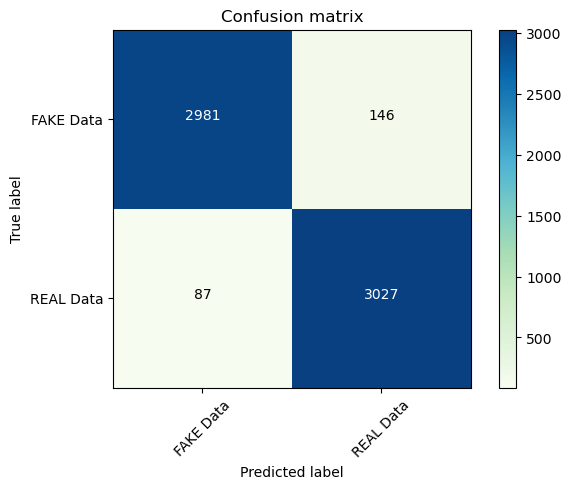

In [58]:
score = accuracy_score(y_test, a)
print(f'Accuracy: {round(score*100,2)}%')
cm = confusion_matrix(y_test, a)
plot_confusion_matrix(cm, classes=['FAKE Data', 'REAL Data'])

In [59]:
from keras.layers import SimpleRNN,LSTM

In [69]:
model = Sequential()
model.add(Embedding(vocabulary_size, 100, input_length=input_length))
model.add(SimpleRNN(units=10, return_sequences=False))
model.add(Dense(units=1))

In [70]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [71]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 12140, 100)        16605500  
                                                                 
 simple_rnn (SimpleRNN)      (None, 10)                1110      
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 16606621 (63.35 MB)
Trainable params: 16606621 (63.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [72]:
model.fit(x_train1,y_train1,epochs=3,validation_data=(x_test, y_test))

Epoch 1/3
455/455 [==============================] - 2882s 6s/step - loss: 0.7130 - accuracy: 0.8058 - val_loss: 0.6941 - val_accuracy: 0.8763
Epoch 2/3
455/455 [==============================] - 3135s 7s/step - loss: 0.2564 - accuracy: 0.9559 - val_loss: 0.8114 - val_accuracy: 0.7906
Epoch 3/3
455/455 [==============================] - 3928s 9s/step - loss: 0.1439 - accuracy: 0.9792 - val_loss: 0.7665 - val_accuracy: 0.8503


In [73]:
Y_pred = model.predict(x_test)
a=[]
for x in Y_pred:
    if x>=0.5:
        a.append(1)
    else:
        a.append(0)

196/196 [==============================] - 65s 328ms/step


Accuracy: 85.03%
Confusion matrix, without normalization


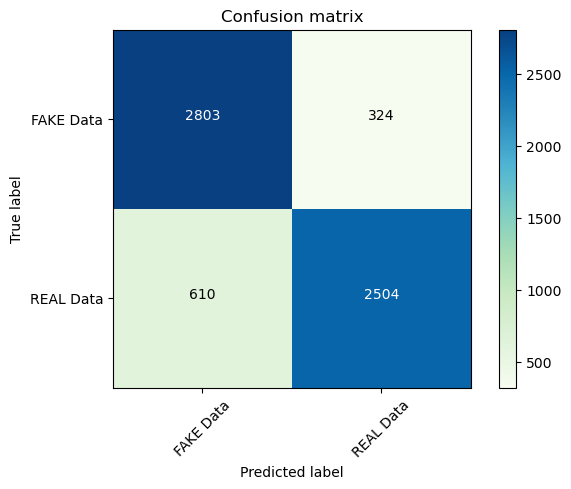

In [74]:
#For second model
score = accuracy_score(y_test, a)
print(f'Accuracy: {round(score*100,2)}%')
cm = confusion_matrix(y_test, a)
plot_confusion_matrix(cm, classes=['FAKE Data', 'REAL Data'])

In [ ]:
#The first model performed better.The second model had good training accuracy but less test accuracy hinting towards overfitting.Maybe the key reason being in fake news it is important to capture overall sentiment better than individual word sentiment.

In [76]:
def fake_news_det(news):
    review = news
    review = re.sub(r'[^a-zA-Z\s]', '', review)
    review = review.lower()
    review = nltk.word_tokenize(review)
    for y in review :
        if y not in stpwrds :
            corpus.append(lemmatizer.lemmatize(y))     
    input_data = [' '.join(corpus)]
    vectorized_input_data_pre = tokenize.texts_to_sequences(input_data)
    vectorized_input_data=pad_sequences(vectorized_input_data_pre, padding="pre", truncating="pre")
    prediction = classifier.predict(vectorized_input_data)
    if prediction[0] == 1:
        print("Prediction of the News :  Looking Fake⚠ News📰 ")
    else:
        print("Prediction of the News : Looking Real News📰 ")

In [77]:
fake_news_det("actor steven seagal live tv erupts hillary obama intense comment actor steven seagal stood america rest hollywood remains silent week rough country first democratic nominee hillary clinton collapsed memorial called million hardworking american deplorable werent enough nfl player throughout country blatantly disrespecting american flag needle say seagal enough think important job secretary state ensuring people dont get killed seagal tweeted cant email protected pneumonia going disastrous american people notohillary continued course seagal quickly became target liberal fire comment refused break particularly lost one twitter user tried argued hillary capable presidency capable capable leaving american die capable disregarding law capable disrespecting rape survivor argued went address race relation united state true role president barack obama played social evolution country obama abysmal race relation usa truth need start honest dialog wrote seagal concluded pointing irony attack receiving liberal everywhere best thing worldmaking one statement freedom getting attacked every demo hypocritical tweeted america without democrat white house safer america think seagals comment")

1/1 [==============================] - 0s 86ms/step
Prediction of the News :  Looking Fake⚠ News📰 
